# Import Corresponding Packages

In [156]:
# Had to install package & upgrade package
# !pip install pyathena
# !pip install --upgrade pyathena pip

In [157]:
import os
import boto3
import sagemaker
import pandas as pd
import numpy as np
import csv, json
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import HTML, display, Image as IImage
from io import StringIO
from pyathena import connect
from sklearn.model_selection import train_test_split
import warnings
import io
from PIL import Image
from skimage import transform
from sklearn.utils import shuffle
import random

warnings.filterwarnings('ignore')

In [158]:
# Initialize Boto3 Rekognition client

rekognition_client = boto3.client("rekognition")
s3 = boto3.client("s3")

# Detect labels in Traffic sign images

In [159]:
# Define s3 bucket name, prefix and output csv file path

bucket_name = 'final.project.data.508'
prefix_key = 'traffic_signs/'
output_csv_key = 'csv_files/traffic_signs.csv'

In [160]:
# Function to detect text from an image 

def detect_text_from_image(bucket_name, image_key):
    if image_key.endswith('.jpg'):
        rekognition_response = rekognition_client.detect_text(Image={'S3Object': {'Bucket': bucket_name, 'Name': image_key}})
        return rekognition_response

In [161]:
# Get a list of objects in the s3 bucket

all_results = []

paginator = s3.get_paginator('list_objects_v2')
result = paginator.paginate(Bucket=bucket_name, Prefix=prefix_key)

for page in result:
    if "Contents" in page:
         for key in page[ "Contents" ]:
             keyString = key[ "Key" ]
             print(keyString)
             if keyString.endswith('.jpg'):
                 response = detect_text_from_image(bucket_name, keyString)
                 all_results.append({'Image': keyString, 'TextDetections': response['TextDetections']})

In [162]:
# # Write aggregated results to a single CSV file

csv_buffer = StringIO()
writer = csv.DictWriter(csv_buffer, fieldnames=['Image', 'DetectedText', 'Type', 'Confidence'])
writer.writeheader()
for result in all_results:
    image_key = result['Image']
    for detection in result['TextDetections']:
        detected_text = detection['DetectedText']
        text_type = detection['Type']
        confidence = detection['Confidence']
        writer.writerow({'Image': image_key, 'DetectedText': detected_text, 'Type': text_type, 'Confidence': confidence})
        
# # Upload CSV string to S3

csv_buffer.seek(0)
s3.put_object(Body=csv_buffer.getvalue(), Bucket=bucket_name, Key=output_csv_key)

print(f"Text detection results saved to: s3://{bucket_name}/{output_csv_key}")

Text detection results saved to: s3://final.project.data.508/csv_files/traffic_signs.csv


In [163]:
# Create athena database

sess = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sess.default_bucket()
region = boto3.Session().region_name

ingest_create_athena_db_passed = False

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [164]:
# Set Athena database name

database_name = "velocityvision"

In [165]:
# Set S3 staging directory -- this is a temporary directory used for Athena queries

s3_staging_dir = "s3://{0}/athena/staging".format(bucket)

In [166]:
# Connect to s3 using PyAthena

conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

In [167]:
# SQL statement to execute

statement = "CREATE DATABASE IF NOT EXISTS {}".format(database_name)
print(statement)
pd.read_sql(statement, conn)

CREATE DATABASE IF NOT EXISTS velocityvision


""


In [168]:
input_data_location = "s3://finalprojectdata/csv_files"

In [169]:
# SQL statement to execute the traffic signs text detection

table_name1 = 'traffic_signs'
pd.read_sql(f'DROP TABLE IF EXISTS {database_name}.{table_name1}', conn)

create_table = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {database_name}.{table_name1}(
            image_id string,
            detected_text string,
            type string,
            confidence float
            )
            
            ROW FORMAT DELIMITED FIELDS TERMINATED BY ','
            LOCATION '{input_data_location}'
            TBLPROPERTIES ('skip.header.line.count'='1')
"""

pd.read_sql(create_table, conn)

pd.read_sql(f'SELECT * FROM {database_name}.{table_name1} LIMIT 5', conn)

,image_id,detected_text,type,confidence
0,license_plate/license_1/00009e5b390986a0.jpg,Bel & The,LINE,98.095120
1,license_plate/license_1/00009e5b390986a0.jpg,Dragen,LINE,89.713400
2,license_plate/license_1/00009e5b390986a0.jpg,a Eating Ноква,LINE,15.457928
3,license_plate/license_1/00009e5b390986a0.jpg,Te Days,LINE,16.091923
4,license_plate/license_1/00009e5b390986a0.jpg,P,LINE,96.585700


In [170]:
# SQL statement to filter rows for "WORD" type

query1 = "SELECT * FROM {}.{} WHERE type='WORD'".format(database_name, table_name1)
traffic_signs_df = pd.read_sql(query1, conn)

In [171]:
traffic_signs_df.shape

(22975, 4)

## Checking duplicate values

In [172]:
traffic_signs_df.duplicated().sum()

7993

In [173]:
# Removing duplicate rows

traffic_signs_df.drop_duplicates(inplace = True)
traffic_signs_df.shape

(14982, 4)

In [174]:
traffic_df = traffic_signs_df.groupby(['image_id', 'type']).agg({'detected_text': ' '.join, 'confidence':'max'}).reset_index()
traffic_df.head()

,image_id,type,detected_text,confidence
0,license_plate/license_1/00009e5b390986a0.jpg,WORD,Bel & The Dragen a Eating Ноква Te Days P طنية...,98.897190
1,license_plate/license_1/00009e5b390986a0_jpg.r...,WORD,MG Dr Bragan Joseph SANG P -,87.967316
2,license_plate/license_1/00009e5b390986a0_jpg.r...,WORD,15 118 and التحج your,83.933174
3,license_plate/license_1/00009e5b390986a0_jpg.r...,WORD,M 10r Вори People Rainy,57.783930
4,license_plate/license_1/0002a5b67e5f0909_jpg.r...,WORD,и Andrews Church DS00 PCZ,98.522736


In [175]:
# SQL statement to execute the analysis of vehicle speed

table_name2 = 'vehicle_speed'
pd.read_sql(f'DROP TABLE IF EXISTS {database_name}.{table_name2}', conn)

create_table = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {database_name}.{table_name2}(
             latitude float,
             longitude float,
             target_speed float,
             way_maxspeed float,
             speed_osrm float,
             elevation float,
             fwd_azimuth float,
             way_type string,
             way_surface string,
             node_intersection string,
             node_railway string,
             node_crossing string,
             node_highway string,
             node_stop string,
             start_stop int,
             azimuth_diff int,
             elevation_diff float
             )
             
             ROW FORMAT DELIMITED FIELDS TERMINATED BY ','
             LOCATION 's3://finalprojectdata/vehicle_speed'
             TBLPROPERTIES ('skip.header.line.count'='1')
"""

pd.read_sql(create_table, conn)

""


In [176]:
vehicle_speed_df = pd.read_sql(f'SELECT * FROM {database_name}.{table_name2}', conn)
vehicle_speed_df.head()

,latitude,longitude,target_speed,way_maxspeed,speed_osrm,elevation,fwd_azimuth,way_type,way_surface,node_intersection,node_railway,node_crossing,node_highway,node_stop,start_stop,azimuth_diff,elevation_diff
0,50.397060,14.913273,39.739456,130.0,28.837246,229.77516,46.24135,motorway,asphalt,,,,,,0,0.0,-0.025587
1,50.397068,14.913283,39.717785,130.0,28.875628,229.74959,46.24135,motorway,asphalt,,,,,,0,0.0,-0.025587
2,50.397076,14.913294,39.696114,130.0,28.914007,229.72400,46.24135,motorway,asphalt,,,,,,0,0.0,-0.025587
3,50.397080,14.913303,39.674442,130.0,28.952387,229.69841,46.24135,motorway,asphalt,,,,,,0,0.0,-0.025587
4,50.397087,14.913314,39.652770,130.0,28.990767,229.67282,46.24135,motorway,asphalt,,,,,,0,0.0,-0.025587


## Conducting Data Cleansing Techniques

In [177]:
# First copied the files from a public to private bucket
# List the contents of the public bucket
# !aws s3 ls s3://finalprojectdata/

# Create folders in your private bucket for each type of data
# !aws s3 mb s3://final.project.data.508/vehicle_type
# !aws s3 mb s3://final.project.data.508/license_plate
# !aws s3 mb s3://final.project.data.508/traffic_signage
# !aws s3 mb s3://final.project.data.508/vehicle_speed

# Copy the contents of each folder from the public bucket to your private bucket
# !aws s3 cp s3://finalprojectdata/cars_type/ s3://final.project.data.508/vehicle_type/ --recursive
# !aws s3 cp s3://finalprojectdata/traffic_signs/ s3://final.project.data.508/traffic_signage/ --recursive
# !aws s3 cp s3://finalprojectdata/license_plate/ s3://final.project.data.508/license_plate/ --recursive
# !aws s3 cp s3://finalprojectdata/vehicle_speed/ s3://final.project.data.508/vehicle_speed/ --recursive

In [178]:
# Function to read the dataset from S3
def read_dataset_from_s3(bucket, prefix):
    s3 = boto3.client('s3')
    objs = s3.list_objects_v2(Bucket=bucket, Prefix=prefix)
    image_paths = [obj['Key'] for obj in objs['Contents']]
    return pd.DataFrame({'image_id': image_paths})

# Function to resize images
def resize_image(image, target_size):
    return transform.resize(image, target_size)

# Function to normalize pixel values
def normalize_image(image):
    return image / 255.0

# Function to perform data augmentation
def augment_data(images, labels, augment_factor):
    augmented_images = []
    augmented_labels = []

    for image, label in zip(images, labels):
        augmented_images.append(image)
        augmented_labels.append(label)

        # Apply transformations and add augmented samples
        for _ in range(augment_factor):
            augmented_image = apply_random_augmentation(image)  # Define your augmentation function
            augmented_images.append(augmented_image)
            augmented_labels.append(label)

    return np.array(augmented_images), np.array(augmented_labels)

# Define a function to apply random augmentations
def apply_random_augmentation(image):
    # Randomly select an augmentation to apply
    augmentation_type = random.choice(["flip_horizontal", "flip_vertical", "rotate", "shift", "brightness"])

    if augmentation_type == "flip_horizontal":
        return np.fliplr(image)
    elif augmentation_type == "flip_vertical":
        return np.flipud(image)
    elif augmentation_type == "rotate":
        return np.rot90(image)
    elif augmentation_type == "shift":
        # Example: Shift the image by a random amount
        shift_amount = random.randint(-10, 10)
        return np.roll(image, shift_amount, axis=random.choice([0, 1]))
    elif augmentation_type == "brightness":
        # Example: Adjust brightness by adding random noise
        brightness_factor = random.uniform(0.5, 1.5)
        return np.clip(image * brightness_factor, 0, 1)

# Set the bucket & prefix for the dataset location
bucket = 'final.project.data.508'
prefix = 'traffic_signage/'

# Read dataset from S3
traffic_df = read_dataset_from_s3(bucket, prefix)

# Resize images to a uniform size
target_size = (32, 32)
resized_images = []
s3 = boto3.client('s3')
for image_path in traffic_df['image_id']:
    obj = s3.get_object(Bucket=bucket, Key=image_path)
    image = Image.open(io.BytesIO(obj['Body'].read()))
    resized_image = resize_image(np.array(image), target_size)
    resized_images.append(resized_image)

# Normalize pixel values
normalized_images = np.array([normalize_image(image) for image in resized_images])

# Perform data augmentation (example with augment_factor=2)
augmented_images, augmented_labels = augment_data(normalized_images, 
                                                  np.zeros(len(normalized_images)),  # Dummy labels
                                                  augment_factor=2)

# Shuffle the augmented data
augmented_images, augmented_labels = shuffle(augmented_images, augmented_labels)

# Save the preprocessed data for training
np.save('augmented_images.npy', augmented_images)
np.save('augmented_labels.npy', augmented_labels)

In [179]:
# Save the preprocessed .npy files into my S3 bucket

# Define the bucket name and prefix
bucket_name = 'final.project.data.508'
prefix = 'pre_processed_signage/'

# Initialize the S3 client
s3 = boto3.client('s3')

# Save augmented_images.npy
augmented_images_key = 'augmented_images.npy'
np.save(augmented_images_key, augmented_images)
s3.upload_file(augmented_images_key, bucket_name, prefix + augmented_images_key)

# Save augmented_labels.npy
augmented_labels_key = 'augmented_labels.npy'
np.save(augmented_labels_key, augmented_labels)
s3.upload_file(augmented_labels_key, bucket_name, prefix + augmented_labels_key)

In [180]:
# Since the .npy format did not work on AutoML, I tried to use csv files

# Load preprocessed data
augmented_images = np.load('augmented_images.npy')
augmented_labels = np.load('augmented_labels.npy')

# Reshape images into a format suitable for CSV
num_images = augmented_images.shape[0]
image_size = augmented_images.shape[1] * augmented_images.shape[2] * augmented_images.shape[3]
reshaped_images = augmented_images.reshape(num_images, image_size)

# Convert to DataFrame
df_images = pd.DataFrame(reshaped_images)
df_labels = pd.DataFrame(augmented_labels, columns=['label'])

# Concatenate images and labels
df = pd.concat([df_images, df_labels], axis=1)

# Save DataFrame to CSV
df.to_csv('augmented_data.csv', index=False)

In [181]:
# Save csv file into bucket

# Define the bucket name and prefix
bucket_name = 'final.project.data.508'
prefix = 'pre_processed_signage/'

# Initialize the S3 client
s3 = boto3.client('s3')

# Upload augmented_data.csv to S3
with open('augmented_data.csv', 'rb') as data:
    s3.upload_fileobj(data, bucket_name, prefix + 'augmented_data.csv')

# Exploratory Data Analysis

### Velocity Dataset

In [182]:
# Load csv from S3 bucket

# Import req'd packages
import pandas as pd
import boto3

# Define S3 bucket and key
bucket = 'velocityspeedproject08'
key = 'datasets/vehicle_speed/vehicle_speed.csv'

# Create a S3 client
s3 = boto3.client('s3')

# Load dataset from S3
obj = s3.get_object(Bucket=bucket, Key=key)
df = pd.read_csv(obj['Body'])

# Preview dataset
df.head()

,latitude,longitude,target_speed,way_maxspeed,speed_osrm,elevation,fwd_azimuth,way_type,way_surface,node:intersection,node:railway,node:crossing,node:highway,node:stop,start_stop,azimuth_diff,elevation_diff
0,50.397062,14.913273,39.739457,130.0,28.837247,229.775169,46.241347,motorway,asphalt,NaN,NaN,NaN,NaN,NaN,0,0.0,-0.025587
1,50.397068,14.913283,39.717786,130.0,28.875627,229.749582,46.241347,motorway,asphalt,NaN,NaN,NaN,NaN,NaN,0,0.0,-0.025587
2,50.397074,14.913294,39.696114,130.0,28.914007,229.723996,46.241347,motorway,asphalt,NaN,NaN,NaN,NaN,NaN,0,0.0,-0.025587
3,50.397080,14.913304,39.674442,130.0,28.952387,229.698409,46.241347,motorway,asphalt,NaN,NaN,NaN,NaN,NaN,0,0.0,-0.025587
4,50.397087,14.913314,39.652771,130.0,28.990767,229.672822,46.241347,motorway,asphalt,NaN,NaN,NaN,NaN,NaN,0,0.0,-0.025587


In [183]:
# Determine shape of df
df.shape

(12165, 17)

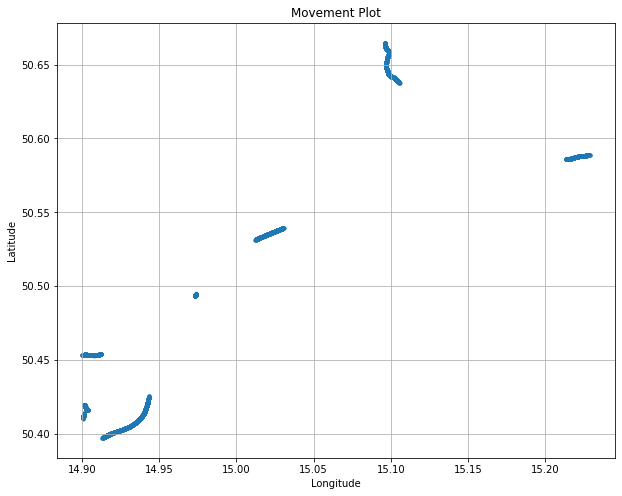

In [184]:
# Plot movement using latitude and longitude
plt.figure(figsize=(10, 8))
plt.scatter(df['longitude'], df['latitude'], alpha=0.5, marker='.')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Movement Plot')
plt.grid(True)
plt.show()

In [185]:
# Define S3 bucket and key
bucket = 'velocityspeedproject08'
key = 'datasets/vehicle_speed/combined_dataset.csv'

# Create a S3 client
s3 = boto3.client('s3')

# Load dataset from S3
obj = s3.get_object(Bucket=bucket, Key=key)
upd_df = pd.read_csv(obj['Body'])

# Preview dataset
upd_df.head()

,latitude,longitude,target_speed,way_maxspeed,speed_osrm,elevation,fwd_azimuth,way_type,way_surface,node:intersection,node:railway,node:crossing,node:highway,node:stop,start_stop,azimuth_diff,elevation_diff,IdentifyingValue
0,50.515393,14.966795,18.272307,90.0,18.2,232.000000,116.775715,secondary,asphalt,NaN,NaN,NaN,NaN,NaN,1,0.0,0.000000,98
1,50.515389,14.966808,18.272307,90.0,18.2,232.054728,116.775715,secondary,asphalt,NaN,NaN,NaN,NaN,NaN,0,0.0,0.054728,98
2,50.515385,14.966820,18.272307,90.0,18.2,232.109455,116.775715,secondary,asphalt,NaN,NaN,NaN,NaN,NaN,0,0.0,0.054728,98
3,50.515381,14.966833,18.272307,90.0,18.2,232.164183,116.775715,secondary,asphalt,NaN,NaN,NaN,NaN,NaN,0,0.0,0.054728,98
4,50.515377,14.966845,18.272307,90.0,18.2,232.218911,116.775715,secondary,asphalt,NaN,NaN,NaN,NaN,NaN,0,0.0,0.054728,98


In [186]:
# Determine shape of df
upd_df.shape

(864906, 18)

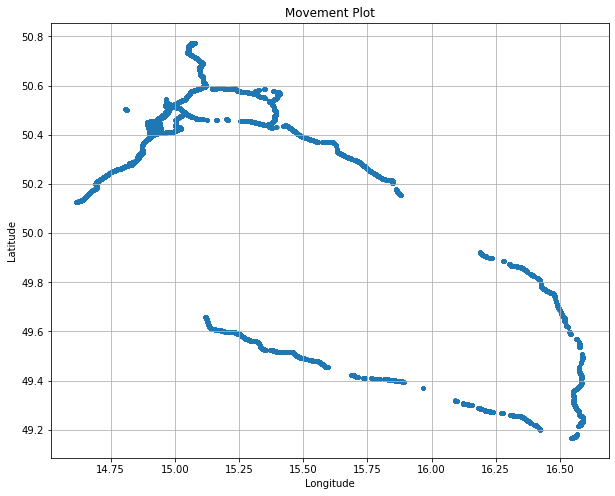

In [187]:
# Plot movement using latitude and longitude
plt.figure(figsize=(10, 8))
plt.scatter(upd_df['longitude'], upd_df['latitude'], alpha=0.5, marker='.')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Movement Plot')
plt.grid(True)
plt.show()

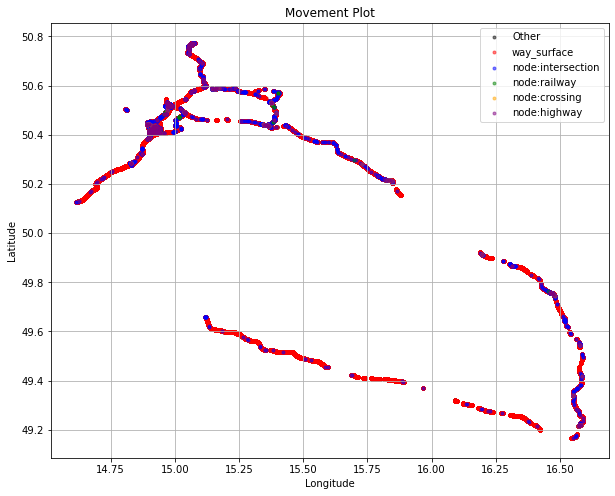

In [188]:
# Define colors for different columns
color_map = {
    'way_surface': 'red',
    'node:intersection': 'blue',
    'node:railway': 'green',
    'node:crossing': 'orange',
    'node:highway': 'purple'
}

# Plot movement using latitude and longitude
plt.figure(figsize=(10, 8))

# Scatter plot for latitude & longitude
plt.scatter(upd_df['longitude'], upd_df['latitude'], alpha=0.5, marker='.', color='black', label='Other')

# Scatter plot for desired columns
for column, color in color_map.items():
    if column in upd_df.columns:
        plt.scatter(upd_df[upd_df[column].notnull()]['longitude'], 
                    upd_df[upd_df[column].notnull()]['latitude'], 
                    alpha=0.5, marker='.', color=color, label=column)

# Add labels & title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Movement Plot')

# Show legend
plt.legend()

plt.grid(True)
plt.show()

In [189]:
vehicle_speed_df.shape

(12165, 17)

Text(0, 0.5, 'Count')

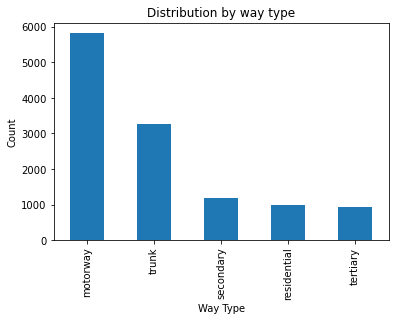

In [190]:
# Distrubition by Way type

vehicle_speed_df['way_type'].value_counts().plot(kind="bar", title="Distribution by way type")
plt.xlabel("Way Type")
plt.ylabel("Count")

# Correlation

Lets study the correlation between different attributes in the dataset

<AxesSubplot:>

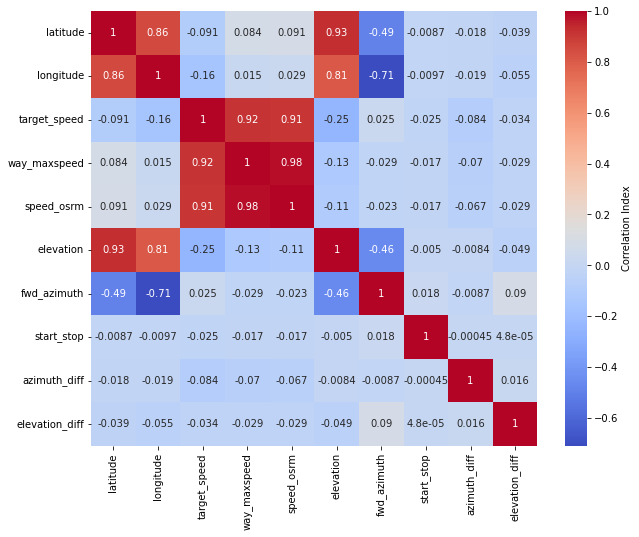

In [191]:
corr = vehicle_speed_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap = 'coolwarm', cbar_kws={'label': 'Correlation Index'})

From the above correlation Heatmap, it is observed that the below predictors are highly correlated.
(1) latitude and elevation
(2) target_speed and way_maxspeed
(3) way_maxspeed and speed_osrm
(4) target_speed and elevation

# 2. Data Preprocessing

## 2.1. Handling Missing Values

In [192]:
vehicle_speed_df.isnull().sum()

latitude             0
longitude            0
target_speed         0
way_maxspeed         0
speed_osrm           0
elevation            0
fwd_azimuth          0
way_type             0
way_surface          0
node_intersection    0
node_railway         0
node_crossing        0
node_highway         0
node_stop            0
start_stop           0
azimuth_diff         7
elevation_diff       0
dtype: int64

In [193]:
# Dropping columns that have null values

vehicle_speed_df = vehicle_speed_df.drop(['node_intersection', 'node_railway', 'node_crossing', 'node_highway', 'node_stop'], axis=1)

# Dropping rows that have null values

vehicle_speed_df = vehicle_speed_df.dropna(subset=['azimuth_diff'])

# Multicollinearity

Lets address the multicollinearity issue by calculating Variance Inflation Factor (VIF) and removing highly correlated predictors.

In [194]:
# Separate the predictors and target variables

X_pred = vehicle_speed_df.drop(['target_speed'], axis=1)
y_target = vehicle_speed_df['target_speed']

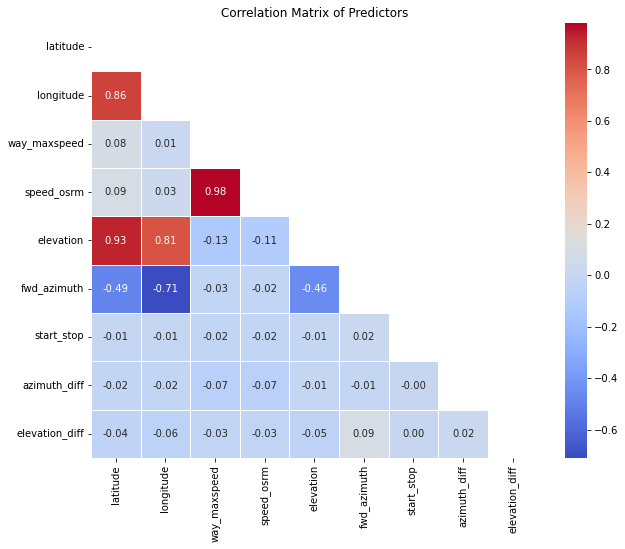

In [195]:
# Calculate correlation matrix for predictors
correlation_matrix = X_pred.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Plot the correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Predictors')
plt.show()

To address the issue of multicollinearity, it is suggested to remove the columns longitude, way_maxspeed, and elevation. However, since determining the target speed of a vehicle relies on multiple factors, including spatial information about the vehicle's location, both latitude and longitude should be taken into account.

# Feature transformation

The maximum allowed speed is measured in km/hr whereas target_speed and speed_osrm are measured in m/s. Hence transforming the target_speed and speed_osrm values to km/hr

In [196]:
# Convert m/s to km/hr for the target_speed and speed_osrm column

vehicle_speed_df['target_speed'] = vehicle_speed_df['target_speed'] * 3.6

vehicle_speed_df['speed_osrm'] = vehicle_speed_df['speed_osrm'] * 3.6

# Feature Creation

Lets create a new feature speed_deviation that computes the difference between target_speed and way_maxspeed to see if the vehicle is driving above or below the allowed speed limit.

In [197]:
vehicle_speed_df['speed_deviation'] = vehicle_speed_df['target_speed'] - vehicle_speed_df['way_maxspeed']

# Drop Irrelevant fields

In [198]:
# Dropping fields that exhibit multicollinearity 

vehicle_speed_df = vehicle_speed_df.drop(['way_maxspeed', 'elevation'], axis=1)

# Dropping irrelevant columns

vehicle_speed_df = vehicle_speed_df.drop(['fwd_azimuth', 'way_surface', 'start_stop', 'azimuth_diff', 'elevation_diff'], axis=1)

# Feature Selection

Based on the insights from the correlation matrix heatmap and other transformation techniques, the useful predictors for the final model include: latitude, longitude, speed_osrm, way_type, speed_deviation and target_speed.

In [199]:
final_df = vehicle_speed_df.copy()

# Encoding Categorical Variables

In [200]:
# Convert categorical variables to dummy variables

final_df = pd.get_dummies(final_df, columns= ['way_type'], drop_first=True)
final_df.head()

,latitude,longitude,target_speed,speed_osrm,speed_deviation,way_type_residential,way_type_secondary,way_type_tertiary,way_type_trunk
0,50.397060,14.913273,143.062042,103.814086,13.062042,0,0,0,0
1,50.397068,14.913283,142.984026,103.952261,12.984026,0,0,0,0
2,50.397076,14.913294,142.906010,104.090425,12.906010,0,0,0,0
3,50.397080,14.913303,142.827991,104.228593,12.827991,0,0,0,0
4,50.397087,14.913314,142.749972,104.366761,12.749972,0,0,0,0


# Data Partitioning

## Separate predictor and target variables

In [201]:
# Separate X and y variables

X = final_df.drop(['target_speed'], axis=1)
y = final_df['target_speed']
predictors = X.columns
outcome = 'target_speed'

## Split dataset into training, test and validation sets

In [202]:
# Split the training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)

# Split the test and validation set
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=1)

In [203]:
# Proportions of training, test and validation data

train_prop = len(X_train)/len(final_df)
test_prop = len(X_test)/len(final_df)
valid_prop = len(X_valid)/len(final_df)

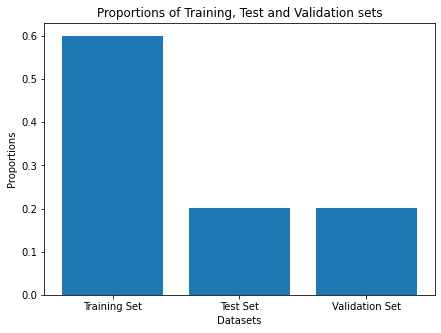

In [204]:
plt.figure(figsize=(7,5))
labels = ['Training Set', 'Test Set', 'Validation Set']
proportions = [train_prop, test_prop, valid_prop]
plt.bar(labels,proportions)
plt.xlabel("Datasets")
plt.ylabel("Proportions")
plt.title("Proportions of Training, Test and Validation sets")
plt.show()

# Create a CNN model to detect traffic signage

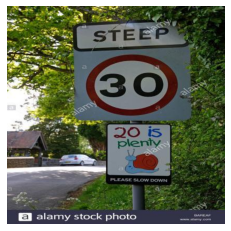

In [205]:
# First ensure access to the S3 file & load an image

# Define the S3 bucket and prefix
bucket_name = 'final.project.data.508'
prefix_key = 'traffic_signage/'
image_key = '000005_jpg.rf.d730849ae93a7c211a7c8f57ed851028.jpg'

# Create a Boto3 S3 client
s3_client = boto3.client('s3')

# Load the image from S3
image_object = s3_client.get_object(Bucket=bucket_name, Key=f'{prefix_key}{image_key}')

# Read the image data from the object
image_data = image_object['Body'].read()

# Open the image using PIL
image = Image.open(io.BytesIO(image_data))

# Display the image
plt.imshow(image)
plt.axis('off')
plt.show()

In [206]:
# Create a Boto3 S3 client
s3_client = boto3.client('s3')

# List objects in the bucket
response = s3_client.list_objects_v2(Bucket=bucket_name, Prefix=prefix_key)

# Extract the filenames from the response
image_filenames = [obj['Key'] for obj in response.get('Contents', [])]

# Shuffle the filenames
random.seed(42)  
random.shuffle(image_filenames)

# Define the ratio for train, validation, & test sets
train_ratio = 0.6
validation_ratio = 0.2
test_ratio = 0.2

# Split the data into train, validation, and test sets
train_filenames, test_filenames = train_test_split(image_filenames, test_size=test_ratio, random_state=42)
train_filenames, validation_filenames = train_test_split(train_filenames, test_size=validation_ratio/(1-test_ratio), random_state=42)

# Print the lengths of each set
print("Number of training examples:", len(train_filenames))
print("Number of validation examples:", len(validation_filenames))
print("Number of test examples:", len(test_filenames))

Number of training examples: 600
Number of validation examples: 200
Number of test examples: 200


In [207]:
# Install required package
# !pip install tensorflow
# !pip install --upgrade numpy
# !pip install --upgrade tensorflow
# !pip install --upgrade numpy h5py tensorflow
# !pip install yolov5
# !apt-get install libgl1-mesa-glx
# !apt-get install libgl1
# !pip install yolov8

In [208]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define input shape (assuming images are 100x100 pixels with 3 color channels)
input_shape = (100, 100, 3)

# Define the CNN model
model = models.Sequential([
    # Convolutional layer with 32 filters, 3x3 kernel size, ReLU activation, and input shape
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    # Max pooling layer with 2x2 pool size
    layers.MaxPooling2D((2, 2)),
    # Convolutional layer with 64 filters, 3x3 kernel size, ReLU activation
    layers.Conv2D(64, (3, 3), activation='relu'),
    # Max pooling layer with 2x2 pool size
    layers.MaxPooling2D((2, 2)),
    # Convolutional layer with 64 filters, 3x3 kernel size, ReLU activation
    layers.Conv2D(64, (3, 3), activation='relu'),
    # Flatten layer to convert 2D features into 1D feature vector
    layers.Flatten(),
    # Dense (fully connected) layer with 64 units and ReLU activation
    layers.Dense(64, activation='relu'),
    # Output layer with 1 unit and sigmoid activation (for binary classification)
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 49, 49, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 23, 23, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 21, 21, 64)        36928     
                                                                 
 flatten_1 (Flatten)         (None, 28224)            

#### Model Summary:

##### Layer (type): This column lists the layers in your model, along with their type.
##### Output Shape: This column shows the shape of the output from each layer. For convolutional layers, it represents the dimensions of the output feature maps.
##### Param #: This column displays the number of parameters (weights and biases) in each layer. These parameters are learned during training.

#### Translation:

##### The first row indicates a convolutional layer (Conv2D) with 32 filters (output channels) and a 3x3 kernel size. The output shape is (98, 98, 32), indicating 32 feature maps of size 98x98.
##### The second row indicates a max-pooling layer (MaxPooling2D) with a 2x2 pool size, which reduces the dimensions of the feature maps by half.
##### The third and fourth rows represent another convolutional layer followed by max-pooling, similar to the first two rows.
##### The fifth row represents a flatten layer, which converts the 2D feature maps into a 1D feature vector.
##### The sixth row represents a dense (fully connected) layer with 64 units and ReLU activation.
##### The seventh row represents the output layer with 1 unit and sigmoid activation, suitable for binary classification tasks.
##### Total params: This line shows the total number of parameters in the model. In your case, the model has 1,862,785 parameters.

In [209]:
# !pip install -U ipywidgets
# !pip install ultralytics

In [210]:
# I tried the YOLO package similar to the kaggle notebook, but with no success

# from ultralytics import YOLO
# import cv2
# from PIL import Image

# Download the YOLOv8 model
# !wget https://github.com/ultralytics/assets/releases/download/v0.0.0/yolov8n.pt

# Load the pretrained YOLOv8 model
# model = YOLO("yolov8n.pt")

# Loop through the images in the training set
# for filename in train_filenames:
    # Define the path to the image
#     image_path = f"s3://{bucket_name}/{filename}"
    
    # Use the model to detect objects in the image
#     result_predict = model.predict(source=image_path, imgsz=(416))
    
    # Display the detection results
#     plot = result_predict[0].plot()
#     plot = cv2.cvtColor(plot, cv2.COLOR_BGR2RGB)
#     Image.fromarray(plot).show()


In [220]:
# import sys, os, distutils.core
# from IPython.display import clear_output

# !python -m pip install pyyaml==5.1
# !git clone 'https://github.com/facebookresearch/detectron2'
# dist = distutils.core.run_setup("./detectron2/setup.py")
# !python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
# sys.path.insert(0, os.path.abspath('./detectron2'))
# clear_output()

# import torch, detectron2
# from detectron2.utils.logger import setup_logger
# setup_logger()
# print("detectron2 version:", detectron2.__version__)

# import numpy as np
# import os, json, cv2, random
# from IPython import display
# import PIL
# import matplotlib.pyplot as plt

# from detectron2 import model_zoo
# from detectron2.engine import DefaultPredictor
# from detectron2.config import get_cfg
# from detectron2.utils.visualizer import Visualizer
# from detectron2.data import MetadataCatalog, DatasetCatalog

# Set your S3 bucket name and file paths
# bucket_name = 'final.project.data.508'

# Define the configuration for the Detectron2 model
# cfg = get_cfg()
# cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml"))
# cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Set threshold for detections

# Load the trained Detectron2 model
# cfg.MODEL.WEIGHTS = "detectron2://COCO-Detection/faster_rcnn_R_50_FPN_1x/137257644/model_final_b275ba.pkl"
# predictor = DefaultPredictor(cfg)

# Loop through the images in the training set
# for filename in train_filenames:
    # Define the path to the image
#     image_path = f"s3://{bucket_name}/{filename}"
    
    # Use the model to detect objects in the image
#     img = cv2.imread(image_path)
#     outputs = predictor(img)
    
    # Display the detection results
#     v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
#     out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
#     plt.imshow(out.get_image()[:, :, ::-1])
#     plt.show()

# Car detection

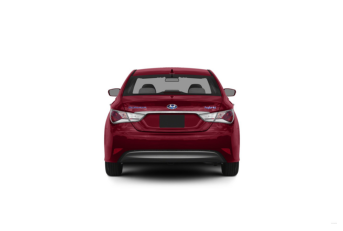

In [212]:
# First ensure access to the S3 file & load an image

# Define the S3 bucket and prefix
bucket_name_car_type = 'final.project.data.508'
prefix_key_car_type = 'vehicle_type_upd/cars_train/cars_train/'
image_key_car_type = '00004.jpg'

# Create a Boto3 S3 client
s3_client = boto3.client('s3')

# Load the image from S3
image_object = s3_client.get_object(Bucket=bucket_name_car_type, Key=f'{prefix_key_car_type}{image_key_car_type}')

# Read the image data from the object
image_data = image_object['Body'].read()

# Open the image using PIL
image = Image.open(io.BytesIO(image_data))

# Display the image
plt.imshow(image)
plt.axis('off')
plt.show()

In [213]:
import boto3

# Define the S3 bucket and prefix
bucket_name = 'final.project.data.508'
prefix_key = 'vehicle_type_upd/'

# Create a Boto3 S3 client
s3_client = boto3.client('s3')

# Define the S3 locations for annotation and image data
annos_mat_location = 's3://final.project.data.508/vehicle_type_upd/cars_annos.mat'
train_images_location = 's3://final.project.data.508/vehicle_type_upd/cars_train/cars_train/'
test_images_location = 's3://final.project.data.508/vehicle_type_upd/cars_test/cars_test/'

# Load training images
training_image_filenames = []
response = s3_client.list_objects_v2(Bucket=bucket_name, Prefix=prefix_key + 'cars_train/cars_train/')
if 'Contents' in response:
    training_image_filenames = [obj['Key'].split('/')[-1] for obj in response['Contents']]
    training_images = [s3_client.get_object(Bucket=bucket_name, Key=obj['Key'])['Body'].read() for obj in response['Contents']]
else:
    print("No training images found.")

# Load testing images
testing_image_filenames = []
response = s3_client.list_objects_v2(Bucket=bucket_name, Prefix=prefix_key + 'cars_test/cars_test/')
if 'Contents' in response:
    testing_image_filenames = [obj['Key'].split('/')[-1] for obj in response['Contents']]
    testing_images = [s3_client.get_object(Bucket=bucket_name, Key=obj['Key'])['Body'].read() for obj in response['Contents']]
else:
    print("No testing images found.")

# Print the number of training and testing images
print("Number of training images:", len(training_images))
print("Number of testing images:", len(testing_images))

Number of training images: 1000
Number of testing images: 1000


Displaying the first 5 training images:


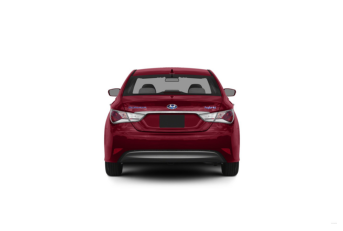

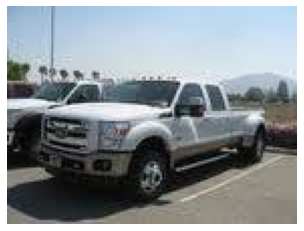

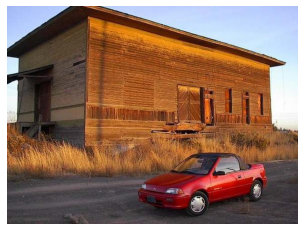

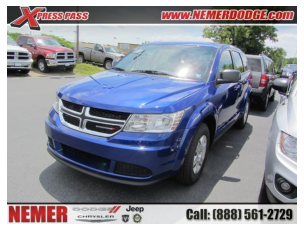

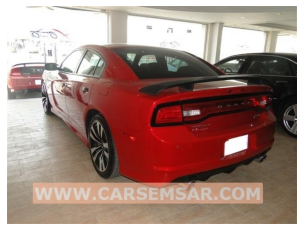

Displaying the first 5 testing images:


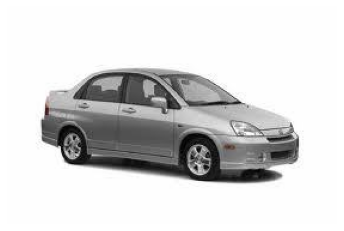

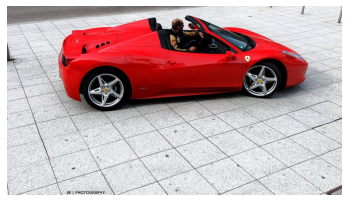

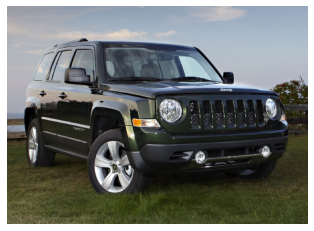

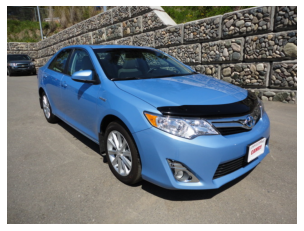

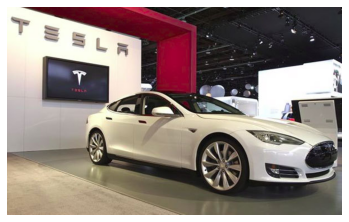

In [214]:
import matplotlib.pyplot as plt
import io
from PIL import Image

# Display the first 10 training images
print("Displaying the first 5 training images:")
for i in range(5):
    try:
        img_bytes = training_images[i]
        img = Image.open(io.BytesIO(img_bytes))
        plt.imshow(img)
        plt.axis('off')
        plt.show()
    except Exception as e:
        print(f"Error displaying training image {i+1}: {e}")

# Display the first 10 testing images
print("Displaying the first 5 testing images:")
for i in range(5):
    try:
        img_bytes = testing_images[i]
        img = Image.open(io.BytesIO(img_bytes))
        plt.imshow(img)
        plt.axis('off')
        plt.show()
    except Exception as e:
        print(f"Error displaying testing image {i+1}: {e}")

In [217]:
# Seeking to understand the format of the referenced files in the annotation file to match them

import boto3
import io
from scipy.io import loadmat

# Assuming you have configured your AWS credentials or are using some other method to authenticate with S3
s3 = boto3.client('s3')

# Define the S3 bucket and key where the annotations file is located
bucket_name = 'final.project.data.508'
annotations_key = 'vehicle_type_upd/cars_annos.mat'

# Download the annotations file from S3
response = s3.get_object(Bucket=bucket_name, Key=annotations_key)
annotations_data = response['Body'].read()

# Load annotations data using scipy.io.loadmat
annotations = loadmat(io.BytesIO(annotations_data))

# Extract filenames from the annotations data
filenames = annotations['annotations']['relative_im_path'][0]

# Print all the filenames
for idx, filename in enumerate(filenames[:10]):
    print(f"Annotation Filename {idx + 1}: {filename[0]}")


Annotation Filename 1: car_ims/000001.jpg
Annotation Filename 2: car_ims/000002.jpg
Annotation Filename 3: car_ims/000003.jpg
Annotation Filename 4: car_ims/000004.jpg
Annotation Filename 5: car_ims/000005.jpg
Annotation Filename 6: car_ims/000006.jpg
Annotation Filename 7: car_ims/000007.jpg
Annotation Filename 8: car_ims/000008.jpg
Annotation Filename 9: car_ims/000009.jpg
Annotation Filename 10: car_ims/000010.jpg


In [221]:
import os
import boto3
from scipy.io import loadmat
import io

# Connect to s3
s3 = boto3.client('s3')

# Define the S3 location for annotations file and train images
bucket_name = 'final.project.data.508'
annotations_key = 'vehicle_type_upd/cars_annos.mat'
train_images_location = 'vehicle_type_upd/cars_train/cars_train/'

# Create function to list all objects
def list_all_objects(bucket_name, prefix):
    s3_client = boto3.client('s3')
    paginator = s3_client.get_paginator('list_objects_v2')
    for page in paginator.paginate(Bucket=bucket_name, Prefix=prefix):
        for obj in page.get('Contents', []):
            yield obj['Key']

# Function to count the total number of files in the specified location
def count_files_in_bucket(bucket_name, prefix):
    total_files = 0
    for _ in list_all_objects(bucket_name, prefix):
        total_files += 1
    return total_files

# Download the annotations file from S3
response = s3.get_object(Bucket=bucket_name, Key=annotations_key)
annotations_data = response['Body'].read()

# Load annotations data using scipy.io.loadmat
annotations = loadmat(io.BytesIO(annotations_data))

# Extract filenames and labels from the annotations data
annotations_filenames = [filename[0].replace('car_ims/', '') for filename in annotations['annotations']['relative_im_path'][0]]
annotations_labels = annotations['annotations']['class'][0]

# Print the first 10 filenames from annotations
print("Annotations filenames and labels:")
for i in range(10):
    print(f"Filename: {annotations_filenames[i].split('/')[-1]}, Label: {annotations_labels[i]}")

# Extract filenames from the train images location
train_files = list(list_all_objects(bucket_name, train_images_location))

# Print the number of train files
print("\nNumber of train files:", len(train_files))

# Print the first 10 filenames from train data subset
print("\nFirst 10 filenames from train data subset:")
for file in train_files[:10]:
    print(f"Filename: {file.split('/')[-1]}")

Annotations filenames and labels:
Filename: 000001.jpg, Label: [[1]]
Filename: 000002.jpg, Label: [[1]]
Filename: 000003.jpg, Label: [[1]]
Filename: 000004.jpg, Label: [[1]]
Filename: 000005.jpg, Label: [[1]]
Filename: 000006.jpg, Label: [[1]]
Filename: 000007.jpg, Label: [[1]]
Filename: 000008.jpg, Label: [[1]]
Filename: 000009.jpg, Label: [[1]]
Filename: 000010.jpg, Label: [[1]]

Number of train files: 5150

First 10 filenames from train data subset:
Filename: 00004.jpg
Filename: 00005.jpg
Filename: 00006.jpg
Filename: 00007.jpg
Filename: 00008.jpg
Filename: 00009.jpg
Filename: 00010.jpg
Filename: 00011.jpg
Filename: 00012.jpg
Filename: 00013.jpg


In [230]:
# Initialize lists to store matched and unmatched files
matched_files = []
unmatched_files = []

# Create an empty dictionary to store the mapping of filenames to labels
label_mapping = {}

# Assign labels to train files
for file in train_files:
    # Extract only the filename
    file_name = file.split('/')[-1]
    # Pad the filename with leading zeros to match the format of annotations_filenames
    padded_file_name = "{:06d}.jpg".format(int(file_name.split('.')[0]))  # Assuming filenames are integers
    if padded_file_name in annotations_filenames:
        # Add matched files to the list
        matched_files.append(file)
        # Find the index of the filename in annotations_filenames
        idx = annotations_filenames.index(padded_file_name)
        # Extract label for the matched file using the index
        label = annotations_labels[idx][0][0]
        # Add the filename and its label to the label_mapping dictionary
        label_mapping[file_name] = label
    else:
        # Add unmatched files to the list
        unmatched_files.append(file)

# Print counts of matched and unmatched files
print(f"\nNumber of matched files: {len(matched_files)}")
print(f"Number of unmatched files: {len(unmatched_files)}")

# Debugging: Print the label_mapping dictionary
print("\nContents of label_mapping:")
print(label_mapping)


Number of matched files: 5150
Number of unmatched files: 0

Contents of label_mapping:
{'00004.jpg': 1, '00005.jpg': 1, '00006.jpg': 1, '00007.jpg': 1, '00008.jpg': 1, '00009.jpg': 1, '00010.jpg': 1, '00011.jpg': 1, '00012.jpg': 1, '00013.jpg': 1, '00018.jpg': 1, '00019.jpg': 1, '00020.jpg': 1, '00021.jpg': 1, '00022.jpg': 1, '00023.jpg': 1, '00024.jpg': 1, '00025.jpg': 1, '00026.jpg': 1, '00027.jpg': 1, '00030.jpg': 1, '00031.jpg': 1, '00032.jpg': 1, '00033.jpg': 1, '00034.jpg': 1, '00035.jpg': 1, '00036.jpg': 1, '00037.jpg': 1, '00038.jpg': 1, '00039.jpg': 1, '00040.jpg': 1, '00041.jpg': 1, '00042.jpg': 1, '00043.jpg': 1, '00044.jpg': 1, '00045.jpg': 1, '00046.jpg': 1, '00047.jpg': 1, '00050.jpg': 1, '00051.jpg': 1, '00052.jpg': 1, '00053.jpg': 1, '00054.jpg': 1, '00055.jpg': 1, '00056.jpg': 1, '00057.jpg': 1, '00068.jpg': 1, '00069.jpg': 1, '00078.jpg': 1, '00079.jpg': 1, '00080.jpg': 1, '00081.jpg': 1, '00082.jpg': 1, '00083.jpg': 1, '00084.jpg': 1, '00085.jpg': 1, '00086.jpg': 1,

In [240]:
# Convert label_mapping dictionary to a DataFrame
df = pd.DataFrame(list(label_mapping.items()), columns=['File Name', 'Class'])

# Sort DataFrame by file name
df = df.sort_values(by='File Name')

# Save DataFrame to a CSV file
df.to_csv('label_mapping.csv', index=False)

print("CSV file 'label_mapping.csv' has been created successfully.")

CSV file 'label_mapping.csv' has been created successfully.


In [242]:
# Display label indicator
df.head(10)

,File Name,Class
0,00004.jpg,1
1,00005.jpg,1
2,00006.jpg,1
3,00007.jpg,1
4,00008.jpg,1
5,00009.jpg,1
6,00010.jpg,1
7,00011.jpg,1
8,00012.jpg,1
9,00013.jpg,1


In [263]:
df.shape

(5150, 2)

In [280]:
import pandas as pd

class_names = [
    'AM General Hummer SUV 2000', 'Acura RL Sedan 2012', 'Acura TL Sedan 2012', 'Acura TL Type-S 2008',
    'Acura TSX Sedan 2012', 'Acura Integra Type R 2001', 'Acura ZDX Hatchback 2012',
    'Aston Martin V8 Vantage Convertible 2012', 'Aston Martin V8 Vantage Coupe 2012',
    'Aston Martin Virage Convertible 2012', 'Aston Martin Virage Coupe 2012', 'Audi RS 4 Convertible 2008',
    'Audi A5 Coupe 2012', 'Audi TTS Coupe 2012', 'Audi R8 Coupe 2012', 'Audi V8 Sedan 1994',
    'Audi 100 Sedan 1994', 'Audi 100 Wagon 1994', 'Audi TT Hatchback 2011', 'Audi S6 Sedan 2011',
    'Audi S5 Convertible 2012', 'Audi S5 Coupe 2012', 'Audi S4 Sedan 2012', 'Audi S4 Sedan 2007',
    'Audi TT RS Coupe 2012', 'BMW ActiveHybrid 5 Sedan 2012', 'BMW 1 Series Convertible 2012',
    'BMW 1 Series Coupe 2012', 'BMW 3 Series Sedan 2012', 'BMW 3 Series Wagon 2012',
    'BMW 6 Series Convertible 2007', 'BMW X5 SUV 2007', 'BMW X6 SUV 2012', 'BMW M3 Coupe 2012',
    'BMW M5 Sedan 2010', 'BMW M6 Convertible 2010', 'BMW X3 SUV 2012', 'BMW Z4 Convertible 2012',
    'Bentley Continental Supersports Conv. Convertible 2012', 'Bentley Arnage Sedan 2009',
    'Bentley Mulsanne Sedan 2011', 'Bentley Continental GT Coupe 2012',
    'Bentley Continental GT Coupe 2007', 'Bentley Continental Flying Spur Sedan 2007',
    'Bugatti Veyron 16.4 Convertible 2009', 'Bugatti Veyron 16.4 Coupe 2009', 'Buick Regal GS 2012',
    'Buick Rainier SUV 2007', 'Buick Verano Sedan 2012', 'Buick Enclave SUV 2012',
    'Cadillac CTS-V Sedan 2012', 'Cadillac SRX SUV 2012', 'Cadillac Escalade EXT Crew Cab 2007',
    'Chevrolet Silverado 1500 Hybrid Crew Cab 2012', 'Chevrolet Corvette Convertible 2012',
    'Chevrolet Corvette ZR1 2012', 'Chevrolet Corvette Ron Fellows Edition Z06 2007',
    'Chevrolet Traverse SUV 2012', 'Chevrolet Camaro Convertible 2012', 'Chevrolet HHR SS 2010',
    'Chevrolet Impala Sedan 2007', 'Chevrolet Tahoe Hybrid SUV 2012', 'Chevrolet Sonic Sedan 2012',
    'Chevrolet Express Cargo Van 2007', 'Chevrolet Avalanche Crew Cab 2012', 'Chevrolet Cobalt SS 2010',
    'Chevrolet Malibu Hybrid Sedan 2010', 'Chevrolet TrailBlazer SS 2009',
    'Chevrolet Silverado 2500HD Regular Cab 2012', 'Chevrolet Silverado 1500 Classic Extended Cab 2007',
    'Chevrolet Express Van 2007', 'Chevrolet Monte Carlo Coupe 2007',
    'Chevrolet Malibu Sedan 2007', 'Chevrolet Silverado 1500 Extended Cab 2012',
    'Chevrolet Silverado 1500 Regular Cab 2012', 'Chrysler Aspen SUV 2009',
    'Chrysler Sebring Convertible 2010', 'Chrysler Town and Country Minivan 2012',
    'Chrysler 300 SRT-8 2010', 'Chrysler Crossfire Convertible 2008', 'Chrysler PT Cruiser Convertible 2008',
    'Daewoo Nubira Wagon 2002', 'Dodge Caliber Wagon 2012', 'Dodge Caliber Wagon 2007',
    'Dodge Caravan Minivan 1997', 'Dodge Ram Pickup 3500 Crew Cab 2010',
    'Dodge Ram Pickup 3500 Quad Cab 2009', 'Dodge Sprinter Cargo Van 2009', 'Dodge Journey SUV 2012',
    'Dodge Dakota Crew Cab 2010', 'Dodge Dakota Club Cab 2007', 'Dodge Magnum Wagon 2008',
    'Dodge Challenger SRT8 2011', 'Dodge Durango SUV 2012', 'Dodge Durango SUV 2007',
    'Dodge Charger Sedan 2012', 'Dodge Charger SRT-8 2009', 'Eagle Talon Hatchback 1998',
    'FIAT 500 Abarth 2012', 'FIAT 500 Convertible 2012', 'Ferrari FF Coupe 2012',
    'Ferrari California Convertible 2012', 'Ferrari 458 Italia Convertible 2012',
    'Ferrari 458 Italia Coupe 2012', 'Fisker Karma Sedan 2012', 'Ford F-450 Super Duty Crew Cab 2012',
    'Ford Mustang Convertible 2007', 'Ford Freestar Minivan 2007', 'Ford Expedition EL SUV 2009',
    'Ford Edge SUV 2012', 'Ford Ranger SuperCab 2011', 'Ford GT Coupe 2006',
    'Ford F-150 Regular Cab 2012', 'Ford F-150 Regular Cab 2007', 'Ford Focus Sedan 2007',
    'Ford E-Series Wagon Van 2012', 'Ford Fiesta Sedan 2012', 'GMC Terrain SUV 2012',
    'GMC Savana Van 2012', 'GMC Yukon Hybrid SUV 2012', 'GMC Acadia SUV 2012',
    'GMC Canyon Extended Cab 2012', 'Geo Metro Convertible 1993', 'HUMMER H3T Crew Cab 2010',
    'HUMMER H2 SUT Crew Cab 2009', 'Honda Odyssey Minivan 2012', 'Honda Odyssey Minivan 2007',
    'Honda Accord Coupe 2012', 'Honda Accord Sedan 2012', 'Hyundai Veloster Hatchback 2012',
    'Hyundai Santa Fe SUV 2012', 'Hyundai Tucson SUV 2012', 'Hyundai Veracruz SUV 2012',
    'Hyundai Sonata Hybrid Sedan 2012', 'Hyundai Elantra Sedan 2007', 'Hyundai Accent Sedan 2012',
    'Hyundai Genesis Sedan 2012', 'Hyundai Sonata Sedan 2012', 'Hyundai Elantra Touring Hatchback 2012',
    'Hyundai Azera Sedan 2012', 'Infiniti G Coupe IPL 2012', 'Infiniti QX56 SUV 2011',
    'Isuzu Ascender SUV 2008', 'Jaguar XK XKR 2012', 'Jeep Patriot SUV 2012',
    'Jeep Wrangler SUV 2012', 'Jeep Liberty SUV 2012', 'Jeep Grand Cherokee SUV 2012',
    'Jeep Compass SUV 2012', 'Lamborghini Reventon Coupe 2008', 'Lamborghini Aventador Coupe 2012',
    'Lamborghini Gallardo LP 570-4 Superleggera 2012', 'Lamborghini Diablo Coupe 2001',
    'Land Rover Range Rover SUV 2012', 'Land Rover LR2 SUV 2012', 'Lincoln Town Car Sedan 2011',
    'MINI Cooper Roadster Convertible 2012', 'Maybach Landaulet Convertible 2012', 'Mazda Tribute SUV 2011',
    'McLaren MP4-12C Coupe 2012', 'Mercedes-Benz 300-Class Convertible 1993',
    'Mercedes-Benz C-Class Sedan 2012', 'Mercedes-Benz SL-Class Coupe 2009',
    'Mercedes-Benz E-Class Sedan 2012', 'Mercedes-Benz S-Class Sedan 2012',
    'Mercedes-Benz Sprinter Van 2012', 'Mitsubishi Lancer Sedan 2012', 'Nissan Leaf Hatchback 2012',
    'Nissan NV Passenger Van 2012', 'Nissan Juke Hatchback 2012', 'Nissan 240SX Coupe 1998',
    'Plymouth Neon Coupe 1999', 'Porsche Panamera Sedan 2012', 'Ram C/V Cargo Van Minivan 2012',
    'Rolls-Royce Phantom Drophead Coupe Convertible 2012', 'Rolls-Royce Ghost Sedan 2012',
    'Rolls-Royce Phantom Sedan 2012', 'Scion xD Hatchback 2012', 'Spyker C8 Convertible 2009',
    'Spyker C8 Coupe 2009', 'Suzuki Aerio Sedan 2007', 'Suzuki Kizashi Sedan 2012',
    'Suzuki SX4 Hatchback 2012', 'Suzuki SX4 Sedan 2012', 'Tesla Model S Sedan 2012',
    'Toyota Sequoia SUV 2012', 'Toyota Camry Sedan 2012', 'Toyota Corolla Sedan 2012',
    'Toyota 4Runner SUV 2012', 'Volkswagen Golf Hatchback 2012', 'Volkswagen Golf Hatchback 1991',
    'Volkswagen Beetle Hatchback 2012', 'Volvo C30 Hatchback 2012', 'Volvo 240 Sedan 1993',
    'Volvo XC90 SUV 2007', 'smart fortwo Convertible 2012'
]

# Creating DataFrame
df_class_vehicle = pd.DataFrame({'Class_Number': range(1, len(class_names) + 1), 'Vehicle_Type': class_names})

# Display class reference
df_class_vehicle

,Class_Number,Vehicle_Type
0,1,AM General Hummer SUV 2000
1,2,Acura RL Sedan 2012
2,3,Acura TL Sedan 2012
3,4,Acura TL Type-S 2008
4,5,Acura TSX Sedan 2012
...,...,...
191,192,Volkswagen Beetle Hatchback 2012
192,193,Volvo C30 Hatchback 2012
193,194,Volvo 240 Sedan 1993
194,195,Volvo XC90 SUV 2007


In [282]:
# Merge df and df_class_vehicle on 'Class' and 'Class_Number'
df_merged = df.merge(df_class_vehicle, left_on='Class', right_on='Class_Number', how='left')

# Drop the 'Class_Number' & 'Class' column as it's redundant
df_merged.drop('Class_Number', axis=1, inplace=True)
df_merged.drop('Class', axis=1, inplace=True)

# Display first 10 rows
df_merged.head(10)

,File Name,Vehicle_Type
0,00004.jpg,AM General Hummer SUV 2000
1,00005.jpg,AM General Hummer SUV 2000
2,00006.jpg,AM General Hummer SUV 2000
3,00007.jpg,AM General Hummer SUV 2000
4,00008.jpg,AM General Hummer SUV 2000
5,00009.jpg,AM General Hummer SUV 2000
6,00010.jpg,AM General Hummer SUV 2000
7,00011.jpg,AM General Hummer SUV 2000
8,00012.jpg,AM General Hummer SUV 2000
9,00013.jpg,AM General Hummer SUV 2000


In [283]:
df_merged.shape

(5150, 2)

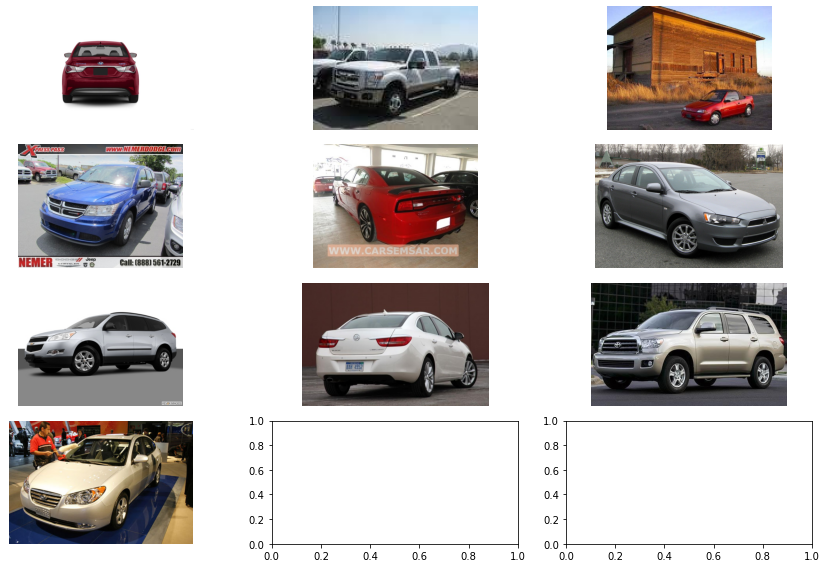

In [293]:
import boto3
import io
import matplotlib.pyplot as plt
from PIL import Image

# Define the S3 bucket and prefix
bucket_name_car_type = 'final.project.data.508'
prefix_key_car_type = 'vehicle_type_upd/cars_train/cars_train/'

# Create a Boto3 S3 client
s3_client = boto3.client('s3')

# Define the range of image numbers
start_index = 4
end_index = 13

# Set up the grid layout
num_cols = 3
num_rows = (end_index - start_index + 1) // num_cols + ((end_index - start_index + 1) % num_cols > 0)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

# Iterate over the range of image numbers and load each image
for i in range(start_index, end_index + 1):
    # Load the image from S3
    image_key_car_type = f'{i:05d}.jpg'  # Format the image number with leading zeros
    image_object = s3_client.get_object(Bucket=bucket_name_car_type, Key=f'{prefix_key_car_type}{image_key_car_type}')
    image_data = image_object['Body'].read()
    
    # Open the image using PIL
    image = Image.open(io.BytesIO(image_data))
    
    # Calculate the row and column indices in the grid
    row_index = (i - start_index) // num_cols
    col_index = (i - start_index) % num_cols
    
    # Display the image on the corresponding subplot
    if num_rows == 1:  # If there's only one row, axes will be 1-dimensional
        axes[col_index].imshow(image)
        axes[col_index].axis('off')
    else:
        axes[row_index, col_index].imshow(image)
        axes[row_index, col_index].axis('off')

# Adjust layout and display the grid of images
plt.tight_layout()
plt.show()

# License Plate Model

In [308]:
import os
import boto3
import tensorflow as tf
import numpy as np
from PIL import Image
from urllib.request import urlopen
import tarfile

# Initialize SageMaker session and S3 client
import sagemaker
from sagemaker import get_execution_role

sagemaker_session = sagemaker.Session()
role = get_execution_role()
s3_client = boto3.client('s3')

# Download the pre-trained SSD model from TensorFlow Model Zoo
model_url = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_coco.tar.gz'
model_local_path = '/tmp/ssd_mobilenet_v2_coco'

if not os.path.exists(model_local_path):
    os.makedirs(model_local_path)

with urlopen(model_url) as response, \
     tarfile.open(fileobj=response, mode='r|gz') as tar:
    tar.extractall(path=model_local_path)

# Load the model
model = tf.saved_model.load(os.path.join(model_local_path, 'saved_model'))

# Function to preprocess image
def preprocess_image(image_path):
    img = Image.open(image_path)
    img = np.array(img)
    img = tf.convert_to_tensor(img)
    img = tf.image.resize(img, (300, 300))
    img = img[tf.newaxis, ...]
    return img

# Function to perform inference on an image
def infer_license_plate(image_path):
    img = preprocess_image(image_path)
    detections = model(img)
    return detections

# Function to parse the detection results
def parse_detections(detections, confidence_threshold=0.5):
    boxes = detections['detection_boxes'][0].numpy()
    scores = detections['detection_scores'][0].numpy()
    classes = detections['detection_classes'][0].numpy().astype(np.int64)
    
    num_detections = np.sum(scores > confidence_threshold)
    
    result = []
    for i in range(num_detections):
        if classes[i] == 10:  # Class 10 represents a car in COCO dataset, you may need to adjust this for your dataset
            ymin, xmin, ymax, xmax = boxes[i]
            result.append({
                'box': [xmin, ymin, xmax, ymax],
                'score': scores[i],
                'class': classes[i]
            })
    return result

# Function to draw bounding boxes on the image
def draw_boxes(image_path, detections):
    img = Image.open(image_path)
    draw = ImageDraw.Draw(img)
    for detection in detections:
        box = detection['box']
        draw.rectangle([(box[1]*img.size[1], box[0]*img.size[0]), (box[3]*img.size[1], box[2]*img.size[0])], outline="red")
    return img

# Function to run license plate detection on images in S3 bucket
def detect_license_plates_in_s3(bucket_name, folder_prefix):
    objects = s3_client.list_objects(Bucket=bucket_name, Prefix=folder_prefix)['Contents']
    for obj in objects:
        image_key = obj['Key']
        if image_key.endswith('.jpg'):
            image_path = os.path.join('/tmp', os.path.basename(image_key))
            s3_client.download_file(bucket_name, image_key, image_path)
            detections = infer_license_plate(image_path)
            parsed_detections = parse_detections(detections)
            image_with_boxes = draw_boxes(image_path, parsed_detections)
            display(image_with_boxes)  # This will display the image with bounding boxes
            os.remove(image_path)  # Remove the downloaded image file

# Example usage
bucket_name = 'final.project.data.508'
folder_prefix = 'license_plate/license_1/'
detect_license_plates_in_s3(bucket_name, folder_prefix)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


HTTPError: HTTP Error 403: Forbidden